<div class="title">Aplicaciones de Análisis &ndash; TensorFlow: Práctica</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

<div style="font-size: large; font-weight: bold; margin-left: 2em;">Nombre: ____________________________</div>

**Configuración Inicial**

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [23]:
def plot_loss(tr_loss = tr_loss, val_loss = val_loss):

    plt.plot(range(len(tr_loss)), tr_loss)
    plt.plot(range(len(val_loss)), val_loss)

    plt.legend(['train', 'validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.show()

# Enunciado

## Introducción

Se dispone de un conjunto de imágenes etiquetadas como: `cloudy`, `rain`, `shine`, y `sunrise`.

## Objetivo

<div class="qst">

* Crear un modelo con Keras que permita determinar, a partir de una imagen de test, la etiqueta correcta.
    * Se requiere una precisión mínima de entrenamiento del $94\%$. Llegado a este punto se deberá parar el entrenamiento.
    * Dada la complejidad del problema, se deberá:
        * Probar diferentes optimizadores.
        * Probar diferentes tasas de aprendizaje.
        * Variar el número de épocas, el tamaño de los *batchs*, el número de pasos por época...
        * Utilizar diferentes *callbacks* para facilitar la experimentación (por ejemplo, guardando los modelos según se va avanzando).
    * Para cada una de estas comprobaciones, se deberá dar una breve explicación de su funcionamiento y de los resultados obtenidos.

</div>

# Dependencias

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

# Esquema

El *notebook* está organizado mostrando un posible ejemplo de la ruta que se puede seguir para afrontar el problema (aunque no es estrictamente necesario seguir este orden).

Como *baseline* y punto de partida, se realiza la carga de los datos, y se entrena un modelo lineal (perceptrón de clasificación).

## Carga de Datos y Preproceso

* Cargar las imágenes.
* Preprocesar las imágenes.
    * Normalizar la escala.
    * Garantizar que el tamaño sea coherente.
* Generar nuevos ejemplos.
* Ajustar tamaño de *batch*.

In [3]:
from tensorflow.keras.preprocessing.image.ImageDataGenerator import ImageDataGenerator

# Parameters.
rescale = 1. / 255
image_size = (150, 150)
batch_size = 32

# The image generator can help to preprocess the images.

# In training, new samples can be generated by modifying this object.
datagen_tr = ImageDataGenerator(
    rescale=rescale
)
# In test (and validation), new samples should not be added.
datagen_te = ImageDataGenerator(
    rescale=rescale
)

# The data is already partitioned by folders, each class is in a different subfolder.
# The following function returns iterators to each dataset.
data_tr = datagen_tr.flow_from_directory(
    "data/train/",
    target_size=image_size,
    batch_size=batch_size
)
data_va = datagen_te.flow_from_directory(
    "data/validation/",
    target_size=image_size,
)
data_te = datagen_te.flow_from_directory(
    "data/test/",
    target_size=image_size,
)

Found 900 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 114 images belonging to 4 classes.


* Ejemplo del conjunto de datos.

Batch shape (input):  (32, 150, 150, 3)
Batch shape (target): (32, 4)


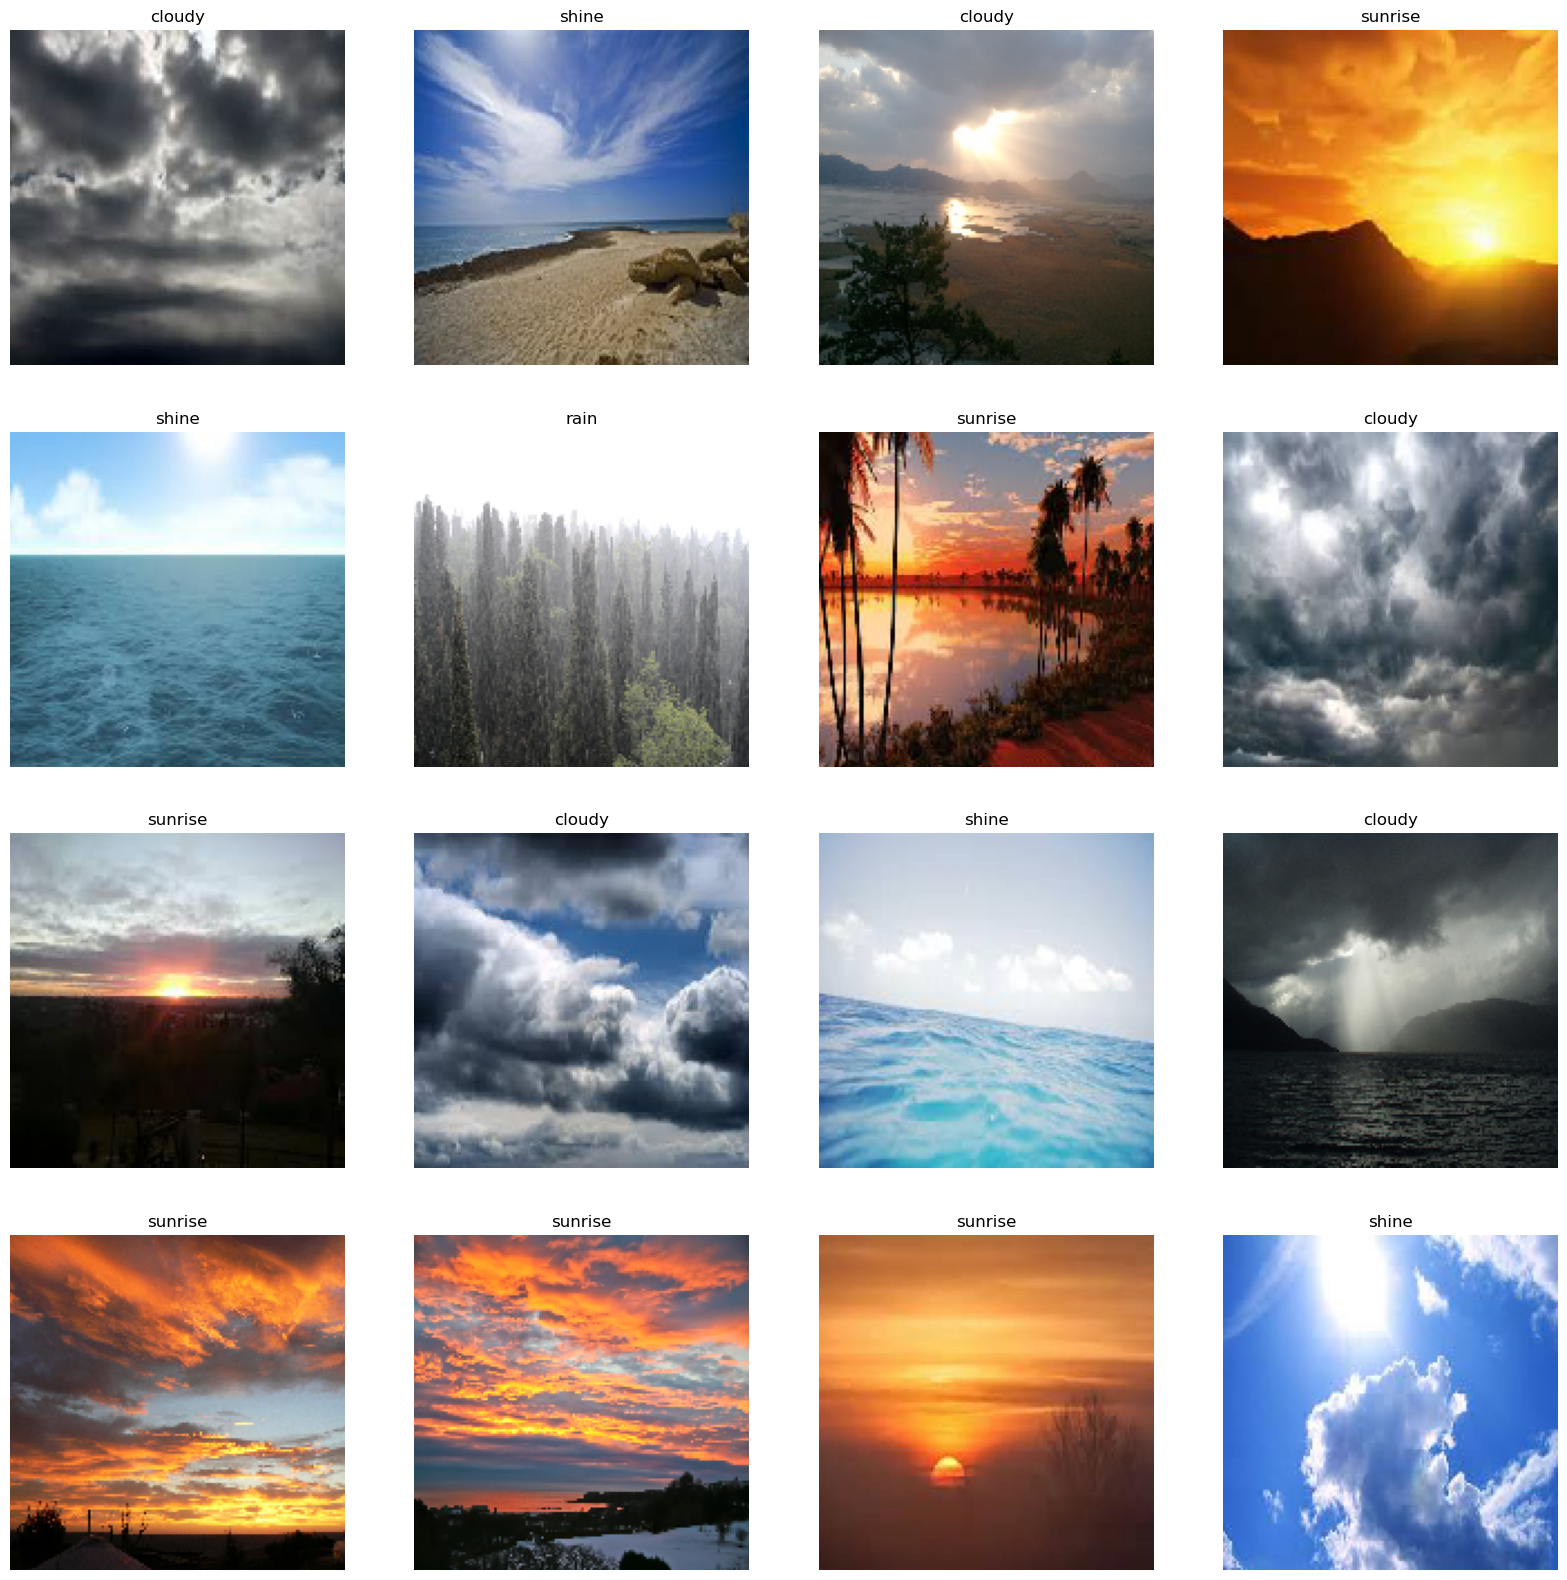

In [4]:
classes = [k for k, v in data_tr.class_indices.items()]

n_rows = 4
n_cols = 4

for batch_x, batch_y in data_tr:
    print("Batch shape (input): ", batch_x.shape)
    print("Batch shape (target):", batch_y.shape)

    plt.figure(figsize=(20, 20))
    for c, x, y in zip(range(len(batch_x)), batch_x, batch_y):
        if c == n_rows * n_cols:
            break

        plt.subplot(n_rows, n_cols, c + 1)
        plt.imshow(x)
        plt.axis("off")
        plt.title(classes[np.where(y)[0][0]])

    plt.show()
    break

## Definición del Modelo

* Ajustar arquitectura.

In [5]:
# A simple perceptron is defined in this case.
model = keras.Sequential(
    [
        keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
        keras.layers.Flatten(),
        keras.layers.Dense(4, activation="softmax")
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 4)                 270004    
                                                                 
Total params: 270,004
Trainable params: 270,004
Non-trainable params: 0
_________________________________________________________________


## Compilación del Modelo

* Ajustar optimizador.
* Ajustar tasa de aprendizaje.

In [6]:
model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Entrenamiento del Modelo

* Definir *callbacks*.
* Ajustar número de épocas.
* Ajustar el número de pasos por época.

In [7]:
history = model.fit(
    data_tr,
    validation_data=data_va,
    epochs=5,
)

Epoch 1/5
29/29 [==============================] - 7s 217ms/step - loss: 20.2274 - accuracy: 0.4667 - val_loss: 7.7348 - val_accuracy: 0.5045
Epoch 2/5
29/29 [==============================] - 6s 219ms/step - loss: 12.4873 - accuracy: 0.5544 - val_loss: 10.0457 - val_accuracy: 0.6216
Epoch 3/5
29/29 [==============================] - 7s 216ms/step - loss: 10.4860 - accuracy: 0.5789 - val_loss: 14.1878 - val_accuracy: 0.6126
Epoch 4/5
29/29 [==============================] - 6s 195ms/step - loss: 9.7564 - accuracy: 0.6033 - val_loss: 12.6499 - val_accuracy: 0.6126
Epoch 5/5
29/29 [==============================] - 6s 204ms/step - loss: 8.8148 - accuracy: 0.6456 - val_loss: 7.0155 - val_accuracy: 0.6577


## Evaluación del Resultado

* Analizar los errores en entrenamiento y test finales.
* Analizar la evolución de los errores durante el entrenamiento, tanto sobre el conjunto de entrenamiento como sobre el de validación.
* Comprobar el resultado sobre algunas imágenes de forma manual.

In [8]:
[loss, acc] = model.evaluate(data_te, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))

Test accuracy: 65.79%


In [15]:
tr_loss, val_loss = history.history['loss'], history.history['val_loss']

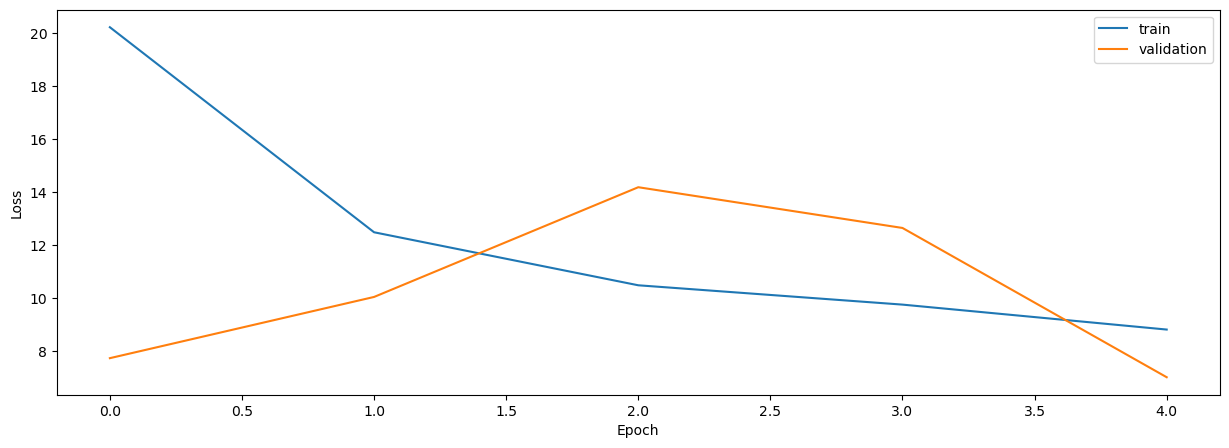

In [22]:

    
plot_loss()